# Recap
The MATLAB model PSD suffers from a "tails" problem. That is, the tails of the PSD run off from the -1 slope we want for simulating flicker noise. These tails (typically seen at the highest and lowest frequencies) are "supporting" or adding unwanted noise to other noise sources oscillating at the same frequencies. 

For example, the tails problem is severe at the highest frequencies of the MATLAB model. So, it is slightly contributing to the effect of white noise (since frequency is related to the inverse of sampling time). As a result, our simulation is not representing an additive model (<-- ?). 

In my previous attempt to quantify "the best" model to use in `AllanOnline` I used a constant set of input parameters (frequency, sampling time, etc.) between each model. I thought that keeping these parameters constant would allow me to simply compare the resulting PSD/Allan Deviations of each model directly. 

However, this choice inherently assumes that the models will only be used to run simulations *at the exact specified parameters*. If that were the case, we might then pick the MATALB model since we can (hand wavingly) say that no one will use the model at frequencies where the tail problem is happening. 

Instead, users will choose the parameters that best suit their device. 

So in this notebook, I'm looking to build intuition on how changing parameters affects the overall shape of the PSD and Allan Deviation when the MATLAB bias instability model is used. 

The investigation will be considered a success if I can "shape" these graphs by changing the inputs.

---

https://outline.com/pCRMng
https://matplotlib.org/stable/api/animation_api.html

In [ ]:
# Clone Allan Online repo to notebook directory
!git clone https://github.com/nurriol2/allan-online.git

from IPython.display import clear_output
clear_output()

In [ ]:
#@title <font size="5">← ឵឵<i>Upgrade FFmpeg to v4.2.2</font> { vertical-output: true }
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


In [ ]:
import sys
import os

# Give access to Allan Online repo files
allan_online_dir = "./allan-online"
sys.path.append(os.path.abspath(allan_online_dir))

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Change the matplotlib backend
%matplotlib notebook
from scipy.signal import welch

# Function for calculating the overlapping Allan deviation of a time series
from allan_variance import overlapping_allan_deviation
# MATLAB Model - Shaping white noise with a filter
from noise_synthesis import simulate_flicker_noise as matlab_model

Need to create some noise density so the Allan deviations have the right shape. 

In [ ]:
# Seed the PRNG for reproducibility
rng = np.random.default_rng(0)

In [ ]:
# These methods will create the ARW and RRW time series that make up the noise density

def make_angle_random_walk_series(coeff, fs, sim_time, generator):
    """Generate an angle random walk noise series

    Args:
        coeff (float): Angle random walk coefficient found on a data sheet
        fs (int or float): Sampling rate in Hz
        sim_time (int or float): Length of the simulation in seconds

    Returns:
        numpy.array: Array of samples making an angle random walk noise time series
    """
    num_samples = int(sim_time*fs)

    arw_psd = coeff**2
    sigma_arw = math.sqrt(arw_psd*fs)
    arw_series = sigma_arw*generator.standard_normal(num_samples)

    return arw_series

def make_rate_random_walk_series(coeff, fs, sim_time, generator):
    """Generate rate random walk noise series by scaling
    a white noise time series.

    Args:
        coeff (float): Rate random walk coefficient
        fs (int or float): Sampling rate in Hz
        sim_time (int or float): Length of simulation in seconds

    Returns:
        numpy.array: Array of values comprising a rate random walk noise time series
    """
    num_samples = int(sim_time*fs)

    rrw_psd = coeff**2
    sigma_rrw = math.sqrt(rrw_psd*fs)
    white_noise_series = sigma_rrw*generator.standard_normal(num_samples)
    rrw_series = (1/fs)*np.cumsum(white_noise_series)

    return rrw_series

In [ ]:
# Constant paramaters shared between each of the models
SAMPLING_RATE = 20 #100 # Hertz
#SIM_TIME = 20000 #10000 # Seconds
SIM_TIME = 1000
NUM_POINTS = SAMPLING_RATE*SIM_TIME
CORRELATION_TIME = 1000 # T_{c}
BI_COEFF = 0.005 #0.01
TRUNCATION  = 5000 # Number of coefficients for the IIR Filter

In [ ]:
def f(x):
    return x**2

# Create figure and axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Reference plot as a variable
allan_reference, = ax.loglog([], [])

# Candidate sampling rates
candidate_range = np.linspace(100, 10_000, num=100)[:10]

def animate(frame):
    
    x = np.linspace(0,1,100)
    y = f(x)
    allan_reference.set_data(x, y)
    return allan_reference, 

ani = FuncAnimation(fig=fig, func=animate, frames=candidate_range, interval=500, repeat=True)
fig.tight_layout()
ani.save("AnimatedPlot.mp4", writer="ffmpeg", fps=2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


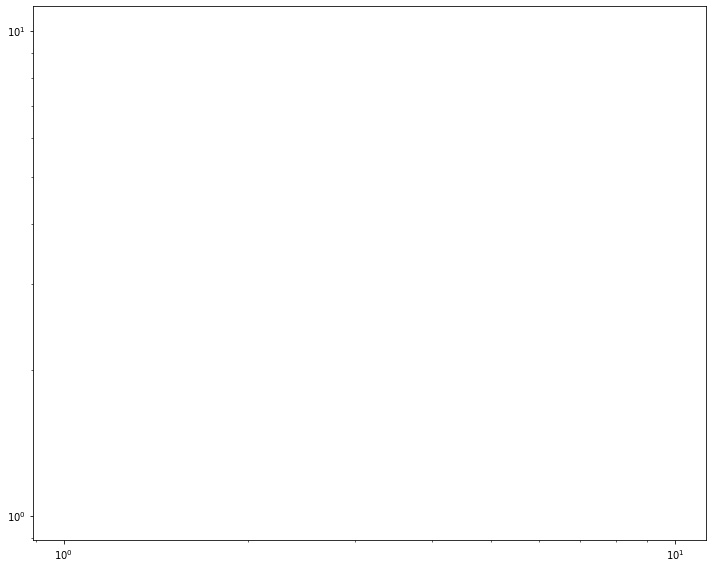

In [ ]:
# Create figure and axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Reference plot as a variable
allan_reference, = ax.loglog([], [])

# Candidate sampling rates
candidate_range = np.linspace(100, 10_000, num=100)[:10]

def animate(frame):
    
    fn = matlab_model(BI_COEFF, frame, SIM_TIME, TRUNCATION)
    arw = make_angle_random_walk_series(coeff=0.025, fs=frame, sim_time=SIM_TIME, generator=rng)
    rrw = make_rate_random_walk_series(coeff=0.01,fs=frame, sim_time=SIM_TIME, generator=rng)
    noise = arw + fn + rrw

    tau, allan_value = overlapping_allan_deviation(noise, frame)
    allan_reference.set_data(tau, allan_value)
    return allan_reference, 

ani = FuncAnimation(fig=fig, func=animate, frames=candidate_range, interval=500, repeat=True)
fig.tight_layout()
ani.save("AnimatedPlot.mp4", writer="ffmpeg", fps=2)

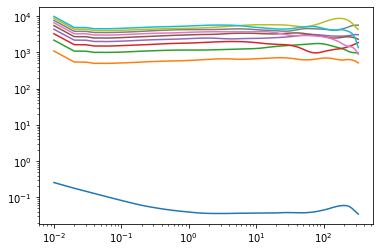

In [ ]:
# Candidate sampling rates
candidate_range = np.linspace(0.005, 10_000, num=100)[:10]

for frame in candidate_range:
    fn = matlab_model(frame, 100, SIM_TIME, TRUNCATION)
    arw = make_angle_random_walk_series(coeff=0.025, fs=100, sim_time=SIM_TIME, generator=rng)
    rrw = make_rate_random_walk_series(coeff=0.01,fs=100, sim_time=SIM_TIME, generator=rng)
    noise = arw + fn + rrw

    tau, allan_value = overlapping_allan_deviation(noise, 100)
    plt.loglog(tau, allan_value)
plt.show()

In [ ]:
plt.plot([1,2,3], [1,2,3])
plt.show()

# Sampling Rate

In [ ]:
sampling_range = np.linspace(100, 10_000, num=100)[:1]
sampling_range

array([100.])

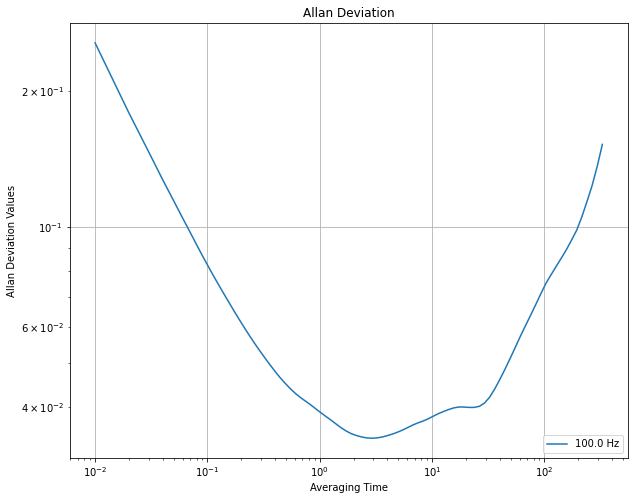

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for num, candidate in enumerate(sampling_range):
    # Create time series
    fn = matlab_model(BI_COEFF, candidate, SIM_TIME, TRUNCATION)
    arw = make_angle_random_walk_series(coeff=0.025, fs=candidate, sim_time=SIM_TIME, generator=rng)
    rrw = make_rate_random_walk_series(coeff=0.01,fs=candidate, sim_time=SIM_TIME, generator=rng)

    noise = fn + arw + rrw

    # Calculate allan deviation values
    tau, allan_value = overlapping_allan_deviation(noise, candidate)
    # Plotting on a single plot
    if num%5==0:
        plt.loglog(tau, allan_value, label=f"{candidate} Hz")
    else:
        plt.loglog(tau, allan_value)

plt.legend(loc="lower right")
plt.grid(b=True)
plt.title("Allan Deviation")
plt.xlabel("Averaging Time")
plt.ylabel("Allan Deviation Values")

plt.show()